In [75]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score

In [47]:
#Read in data
w_basket_data = pd.read_csv('W_Basket_CMJ.csv')
w_basket_df= pd.DataFrame(w_basket_data)
w_basket_df.dropna()

#Printing the first 5 rows
print(w_basket_df.head())

                 TestId        Date      Time                  Name  Segment  \
0  Xj5YxalUvL4V3dKlEjVl  03/19/2025  14:14:29  5E9krELhCQ7yLvDGYsGo      NaN   
1  yVFT5nJ91FhYkFRHC0Z8  03/19/2025  14:13:00  5E9krELhCQ7yLvDGYsGo      NaN   
2  2UV2hDfm5NDmkuCjVsbl  03/11/2025  10:38:38  5E9krELhCQ7yLvDGYsGo      NaN   
3  uU2nvcJ74jje5Xj5beXP  03/11/2025  10:37:50  5E9krELhCQ7yLvDGYsGo      NaN   
4  AYm2iNAtPB6C09QOz6Qb  03/11/2025  10:36:13  5E9krELhCQ7yLvDGYsGo      NaN   

   Position                  Type  Excluded  Tags  System Weight  ...  \
0       NaN  Countermovement Jump       NaN   NaN        656.367  ...   
1       NaN  Countermovement Jump       NaN   NaN        657.101  ...   
2       NaN  Countermovement Jump       NaN   NaN        650.532  ...   
3       NaN  Countermovement Jump       NaN   NaN        650.637  ...   
4       NaN  Countermovement Jump       NaN   NaN        650.531  ...   

   Right Avg. Landing Force  L|R Landing Impulse Index     RSI    mRSI  \
0     

In [48]:
#Creating a new dataset with filtered metrics
metric_df= pd.DataFrame(w_basket_df[['TestId','Date', 'Time', 'Name', 'Jump Height', 'Avg. Braking Force', 'Avg. Propulsive Power',
                       'Time To Takeoff','Left Avg. Braking Force', 'Right Avg. Braking Force', 'L|R Avg. Braking Force', 'Peak Propulsive Power']])
print(metric_df.head())

                 TestId        Date      Time                  Name  \
0  Xj5YxalUvL4V3dKlEjVl  03/19/2025  14:14:29  5E9krELhCQ7yLvDGYsGo   
1  yVFT5nJ91FhYkFRHC0Z8  03/19/2025  14:13:00  5E9krELhCQ7yLvDGYsGo   
2  2UV2hDfm5NDmkuCjVsbl  03/11/2025  10:38:38  5E9krELhCQ7yLvDGYsGo   
3  uU2nvcJ74jje5Xj5beXP  03/11/2025  10:37:50  5E9krELhCQ7yLvDGYsGo   
4  AYm2iNAtPB6C09QOz6Qb  03/11/2025  10:36:13  5E9krELhCQ7yLvDGYsGo   

   Jump Height  Avg. Braking Force  Avg. Propulsive Power  Time To Takeoff  \
0       0.4163           1385.0155              2363.5456            0.622   
1       0.4044           1398.4769              2307.5014            0.603   
2       0.4003           1359.5469              2252.8850            0.693   
3       0.3627           1371.9685              2139.8421            0.653   
4       0.3967           1335.5441              2280.3264            0.632   

   Left Avg. Braking Force  Right Avg. Braking Force  L|R Avg. Braking Force  \
0                 665.97

In [49]:
#Pulling the month out of the Date column 
metric_df['month'] = pd.DatetimeIndex(metric_df['Date']).month
month_df = metric_df['month']

Athlete Readiness Classification 

In [50]:
#Athlete Readiness Classification based on daily and overall jump height
def ready_jump_classify(metric_df):
    readiness_jump_results = []
    
    #Creating a list of the Athlete_IDs
    all_athletes = metric_df['Name'].unique()

    #Looping through each athlete
    for athlete in all_athletes:
        athlete_data = metric_df[metric_df['Name'] == athlete]
        overall_avg = athlete_data['Jump Height'].mean()
        
        # Looping through each jump individually
        for jumps in range(len(athlete_data)):  
            jump = athlete_data.iloc[jumps][ 'Jump Height']  
            date = athlete_data.iloc[jumps]['Date']
            test_id = athlete_data.iloc[jumps]['TestId']

            #Defining the percent change formula
            percent_change = abs((jump -overall_avg)/ overall_avg) * 100 #change here too

            #Creating the readiness classification based on the percent change
            if percent_change < 10:
                readiness_score = 5
            elif 10 <= percent_change < 15:
                readiness_score = 4
            elif 15 <= percent_change < 20:
                readiness_score = 3
            elif 20 <= percent_change < 25:
                readiness_score = 2
            else:
                readiness_score = 1

            #Creating a list of the results 
            readiness_jump_results.append({
                "Athlete_ID" : athlete,
                "TestID" : test_id,
                "Date" : date,
                "Jump" : jump,
                "Overall_Avg" : overall_avg, 
                "Percent_Change" : percent_change,
                "Readiness_Percent_Score" : readiness_score
            })

    #Turning the results list into a dataframe 
    return pd.DataFrame(readiness_jump_results)

readiness_jump_df = ready_jump_classify(metric_df)
readiness_jump_df= readiness_jump_df.dropna()


In [51]:
#Creating a new dataframe with all the metrics and the readiness scores per jump 
athlete_df = pd.concat([metric_df, readiness_jump_df.drop(['Athlete_ID', 'TestID', 'Date', 'Jump'], axis=1)], axis=1)

In [52]:
athlete_df

,TestId,Date,Time,Name,Jump Height,Avg. Braking Force,Avg. Propulsive Power,Time To Takeoff,Left Avg. Braking Force,Right Avg. Braking Force,L|R Avg. Braking Force,Peak Propulsive Power,month,Overall_Avg,Percent_Change,Readiness_Percent_Score
0,Xj5YxalUvL4V3dKlEjVl,03/19/2025,14:14:29,5E9krELhCQ7yLvDGYsGo,0.4163,1385.0155,2363.5456,0.622,665.9767,719.0388,-3.8311,4091.0534,3,0.371101,12.179825,4
1,yVFT5nJ91FhYkFRHC0Z8,03/19/2025,14:13:00,5E9krELhCQ7yLvDGYsGo,0.4044,1398.4769,2307.5014,0.603,656.0923,742.3846,-6.1704,3905.5816,3,0.371101,8.973148,5
2,2UV2hDfm5NDmkuCjVsbl,03/11/2025,10:38:38,5E9krELhCQ7yLvDGYsGo,0.4003,1359.5469,2252.8850,0.693,631.5156,728.0313,-7.0991,3874.6018,3,0.371101,7.868326,5
3,uU2nvcJ74jje5Xj5beXP,03/11/2025,10:37:50,5E9krELhCQ7yLvDGYsGo,0.3627,1371.9685,2139.8421,0.653,619.1260,752.8425,-9.7463,3527.0024,3,0.371101,2.263698,5
4,AYm2iNAtPB6C09QOz6Qb,03/11/2025,10:36:13,5E9krELhCQ7yLvDGYsGo,0.3967,1335.5441,2280.3264,0.632,643.3456,692.1985,-3.6579,3713.1294,3,0.371101,6.898239,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,GCXEPCTuDFyDsdns7cah,08/23/2024,12:55:51,w2W0rInDu6nt5ukwWIwL,0.2725,1653.5085,2156.8528,0.599,865.7797,787.7288,4.7203,3600.8802,8,0.276275,1.366549,5
1953,jOTq4kVz1hdovK7ejyk1,08/23/2024,12:53:20,w2W0rInDu6nt5ukwWIwL,0.2682,1741.2336,2196.0888,0.601,926.3645,814.8692,6.4032,3556.9095,8,0.276275,2.922967,5
1954,zxFP12CyxoJmYIjbyqLH,08/22/2024,16:43:39,w2W0rInDu6nt5ukwWIwL,0.2675,1837.8941,2529.6503,0.538,955.0118,882.8824,3.9246,4010.4884,8,0.276275,3.176337,5
1955,jf3lBXcvjvUYNrNZv2Rg,08/22/2024,16:42:00,w2W0rInDu6nt5ukwWIwL,0.2667,1757.9895,2415.1438,0.571,938.2632,819.7263,6.7428,3851.3013,8,0.276275,3.465903,5


In [53]:
#Athlete Readiness Classification Based on Quintiles 
jump_height_array = athlete_df['Jump Height'].values

q1 = np.percentile(athlete_df['Jump Height'].values, 20)
q2 = np.percentile(athlete_df['Jump Height'].values, 40)
q3 = np.percentile(athlete_df['Jump Height'].values, 60)
q4 = np.percentile(athlete_df['Jump Height'].values, 80)

quint_ready = []
for i, jump in enumerate(jump_height_array):
    if jump < q1:
        quint_ready.append(1)
    elif jump < q2:
        quint_ready.append(2)
    elif jump < q3:
        quint_ready.append(3)
    elif jump < q4:
        quint_ready.append(4)
    else:
        quint_ready.append(5)

athlete_df['Readiness_Quint_Score'] = quint_ready


Principal Component Analysis 

In [54]:
#Scaling the data
scaler = StandardScaler(with_std = True, with_mean = True)
athlete_scaled = scaler.fit_transform(athlete_df.drop(['TestId', 'Date', 'Time', 'Name', 'Jump Height', 'Percent_Change', 'Overall_Avg', 'Readiness_Percent_Score',
                                                       'Readiness_Quint_Score','month'], axis=1))

In [55]:
athlete_scaled[:10]

array([[-0.08190861,  1.37033951, -0.98586675, -0.12766683, -0.02820628,
        -0.12368489,  1.00752116],
       [-0.02152177,  1.15691123, -1.16180775, -0.21427844,  0.15028415,
        -0.44377932,  0.58142958],
       [-0.19615886,  0.94892032, -0.32840301, -0.42963066,  0.04054592,
        -0.57085652,  0.51025849],
       [-0.14043648,  0.51842882, -0.69880512, -0.53819397,  0.23024008,
        -0.93308197, -0.28829512],
       [-0.30383364,  1.05342303, -0.89326622, -0.32597082, -0.23341394,
        -0.09998534,  0.13930167],
       [-0.25572164,  1.26370915, -1.41182917, -0.29516291, -0.17829596,
        -0.1335369 ,  0.28302778],
       [-0.56433987,  0.43153529, -0.53212417, -0.63525918, -0.40753956,
        -0.25686487, -0.37439317],
       [-0.31453437,  0.6829086 , -1.35626885, -0.79959814,  0.16160333,
        -1.18596382, -0.18704358],
       [-0.70311154,  0.33497346, -1.27292838, -0.43362546, -0.81998399,
         0.57157942, -0.19871361],
       [-0.16531408,  0.9143

In [56]:
#Setting up PCA 
pca_athlete = PCA()
pca_athlete.fit(athlete_scaled)

PCA()

In [57]:
pca_athlete.mean_

array([-8.71386084e-16,  5.15570100e-16, -2.32369622e-16,  1.03840175e-15,
       -5.80924056e-17,  2.90462028e-17, -1.00209400e-15])

In [58]:
scores = pca_athlete.transform(athlete_scaled)

In [59]:
scores[:10]

array([[ 1.03106377e+00,  2.39071663e-01, -5.01942884e-01,
        -1.58137941e+00,  1.72209423e-01,  3.67768156e-02,
         2.21705150e-09],
       [ 9.30611226e-01, -3.65462761e-01, -4.14143406e-01,
        -1.44237232e+00,  2.00182094e-01,  2.40669114e-02,
        -2.21938982e-09],
       [ 3.95160962e-01, -1.41229455e-01, -8.65839212e-01,
        -8.97193132e-01,  2.97409089e-01,  7.79770693e-03,
        -5.82575931e-09],
       [ 1.25426987e-01, -1.08830895e+00, -5.00987592e-01,
        -7.06730859e-01,  3.49959766e-01, -1.27079208e-02,
        -1.28523515e-08],
       [ 3.15829739e-01, -1.42100394e-01, -1.33291445e-01,
        -1.32749904e+00,  5.38397024e-01, -1.57464351e-02,
        -8.30271460e-09],
       [ 6.35356258e-01, -2.96057966e-01, -2.92747295e-02,
        -1.77539726e+00,  4.77745169e-01,  1.61734181e-03,
        -6.21333559e-09],
       [-5.41753025e-01, -4.26344767e-01, -1.15991161e-01,
        -9.00689628e-01,  5.12768578e-01, -2.75187890e-02,
        -1.2061056

Text(0, 0.5, 'PC2')

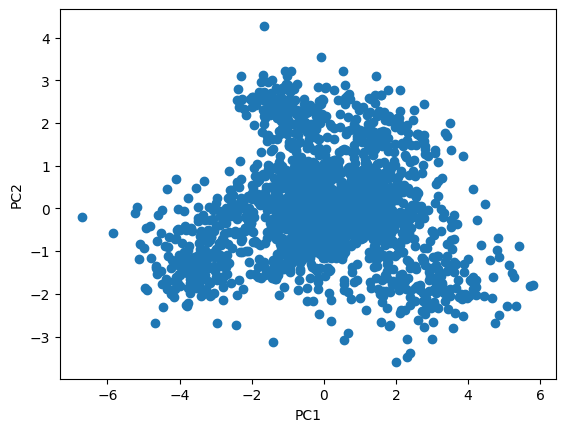

In [60]:
PC1= scores.T[0]
PC2= scores.T[1]
plt.scatter(PC1, PC2)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [61]:
pca_athlete.explained_variance_

array([3.69330665e+00, 1.53597324e+00, 1.14440354e+00, 5.47536941e-01,
       7.73250905e-02, 5.03326735e-03, 3.23356272e-14])

In [62]:
pca_athlete.explained_variance_ratio_

array([5.27345632e-01, 2.19312625e-01, 1.63402681e-01, 7.81795940e-02,
       1.10407969e-02, 7.18670774e-04, 4.61701487e-15])

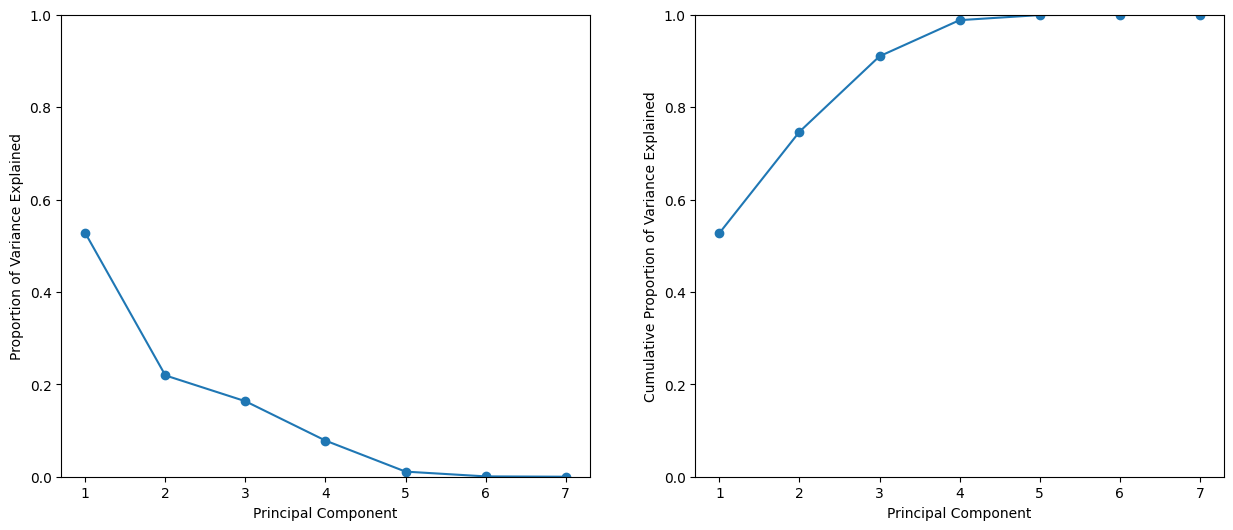

In [63]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
ticks = np.arange(pca_athlete.n_components_)+1
ax = axes[0]
ax.plot(ticks,pca_athlete.explained_variance_ratio_, marker = 'o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

ax = axes[1]
ax.plot(ticks, pca_athlete.explained_variance_ratio_.cumsum(),marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Avg. Braking Force'),
  Text(1, 0, 'Avg. Propulsive Power'),
  Text(2, 0, 'Time To Takeoff'),
  Text(3, 0, 'Left Avg. Braking Force'),
  Text(4, 0, 'Right Avg. Braking Force'),
  Text(5, 0, 'L|R Avg. Braking Force'),
  Text(6, 0, 'Peak Propulsive Power')])

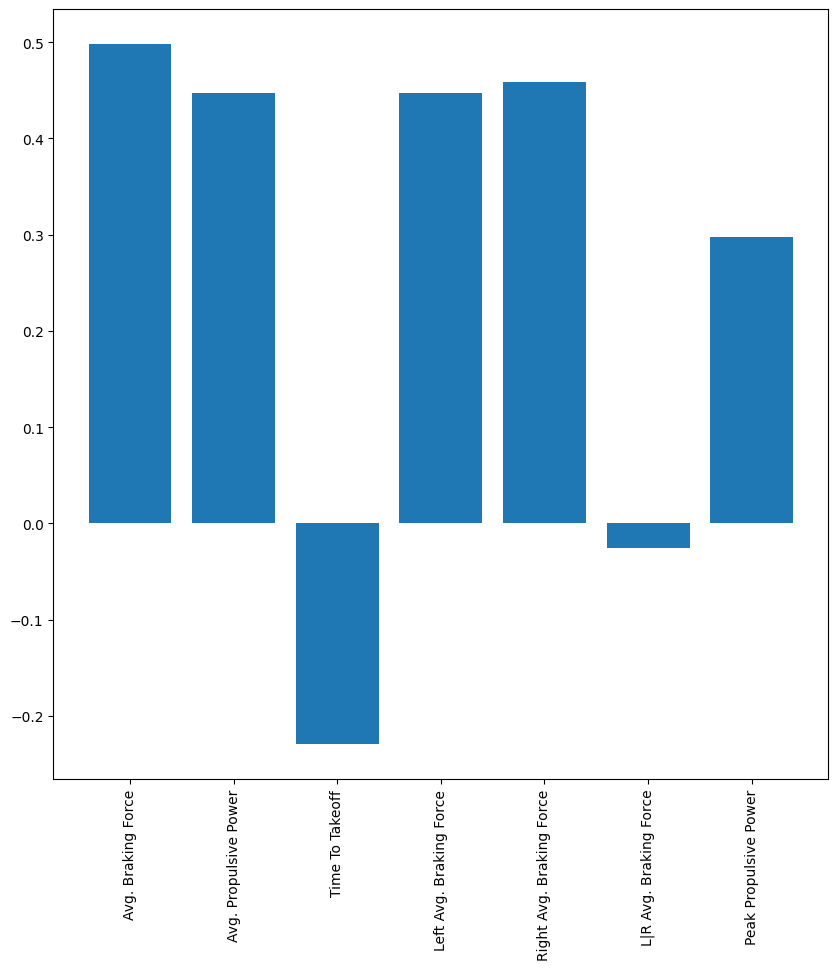

In [64]:
#Graphing the linear combination for PC1 
plt.figure(figsize=(10,10))
plt.bar(height=pca_athlete.components_[0], x=athlete_df.drop(['TestId', 'Date', 'Time', 'Name', 'Jump Height', 'Percent_Change', 'Overall_Avg', 'Readiness_Percent_Score',
                                                              'Readiness_Quint_Score','month'],axis=1).columns)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Avg. Braking Force'),
  Text(1, 0, 'Avg. Propulsive Power'),
  Text(2, 0, 'Time To Takeoff'),
  Text(3, 0, 'Left Avg. Braking Force'),
  Text(4, 0, 'Right Avg. Braking Force'),
  Text(5, 0, 'L|R Avg. Braking Force'),
  Text(6, 0, 'Peak Propulsive Power')])

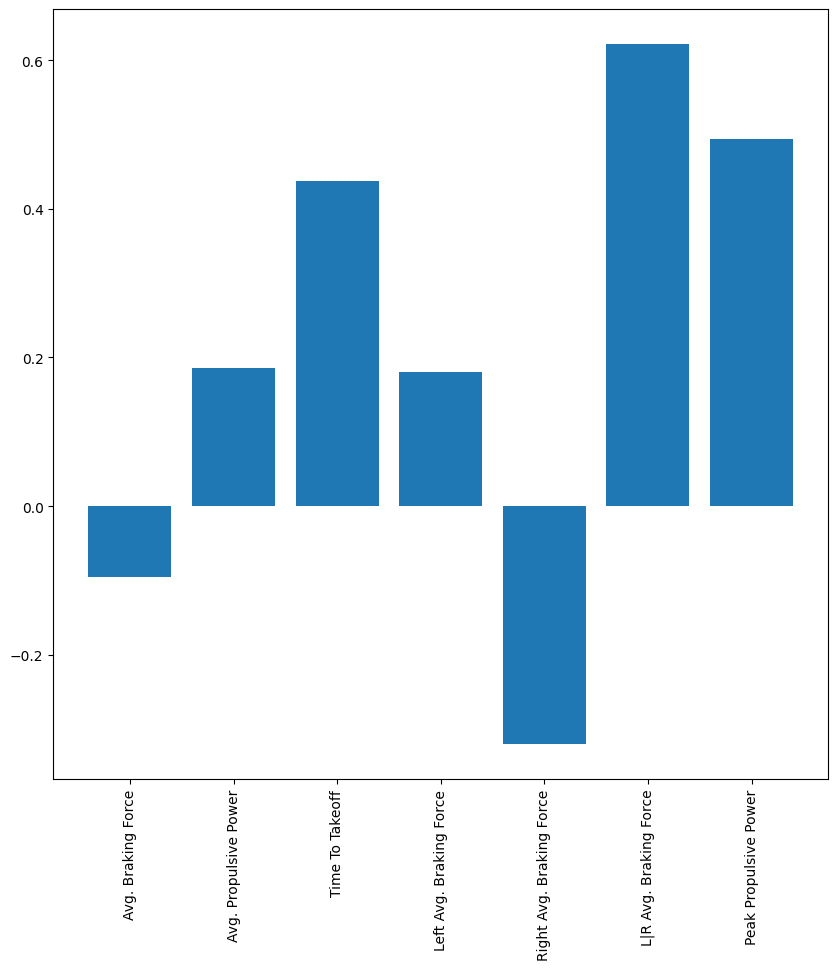

In [65]:
#Graphing the linear combination for PC2
plt.figure(figsize=(10,10))
plt.bar(height=pca_athlete.components_[1], x=athlete_df.drop(['TestId', 'Date', 'Time', 'Name', 'Jump Height', 'Percent_Change', 'Overall_Avg', 'Readiness_Percent_Score',
                                                              'Readiness_Quint_Score','month'], axis=1).columns)
plt.xticks(rotation=90)

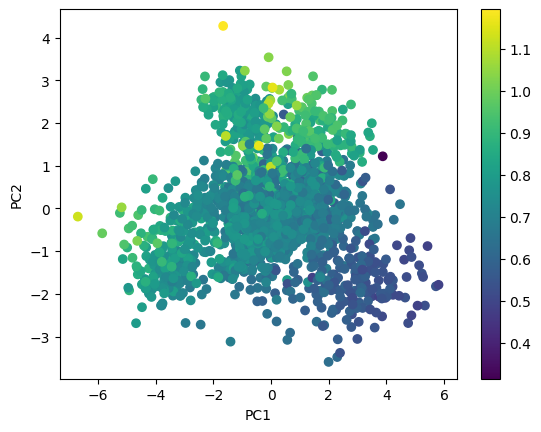

In [66]:
PC1= scores.T[0]
PC2= scores.T[1]
plt.scatter(PC1, PC2, c=athlete_df['Time To Takeoff'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

Using PCA to improve Random Forest

In [67]:
target = athlete_df['Readiness_Quint_Score']
X_train, X_test, y_train, y_test = train_test_split(scores, target, test_size=0.25, random_state=42)

rf_pca_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca_model.fit(X_train, y_train)

y_pred = rf_pca_model.predict(X_test)

#Model accuracy score 
kappa_rf_pca = cohen_kappa_score(y_test, y_pred, weights="quadratic")
print(kappa_rf_pca)


0.8381621221448043


Text(77.92222222222227, 0.5, 'Predicted label')

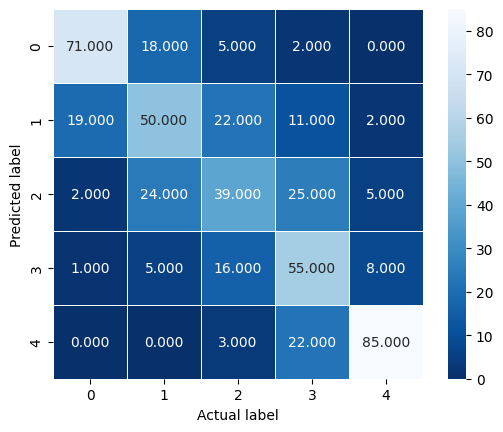

In [68]:
conf_pca = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_pca, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Actual label') 
plt.ylabel('Predicted label')

Using Principal Component Analysis to improve Linear Discriminate Analysis

In [69]:
# Step 1: Apply PCA
X_pca = pca_athlete.fit_transform(athlete_scaled)

# Step 2: Split into train & test
train_mask = (month_df < 9)
X_train, X_test = X_pca[train_mask], X_pca[~train_mask]
Y = athlete_df['Readiness_Quint_Score']
Y_train, Y_test = Y.loc[train_mask], Y.loc[~train_mask]

# Step 3: Fit LDA model
lda_pca = LDA(store_covariance=True)
lda_pca.fit(X_train, Y_train)

# Step 4: Make predictions
lda_pca_pred = lda_pca.predict(X_test)

In [70]:
lda_pca_pred

array([3, 5, 5, ..., 1, 1, 1], shape=(1160,))

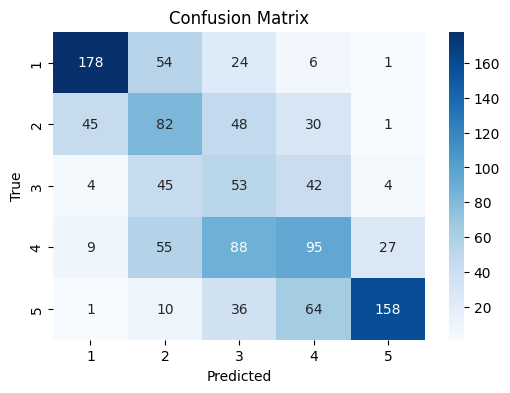

In [71]:
#Confusion Matrix for Quintiles LDA
cm_pca=confusion_matrix(lda_pca_pred, Y_test)

labels = ['1', '2', '3', '4', '5']
plt.figure(figsize=(6, 4))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [72]:
#Quadratic Weighted Kappa
kappa_lda_pca = cohen_kappa_score(Y_test, lda_pca_pred, weights="quadratic")
print(kappa_lda_pca)

0.7319870285129322


In [73]:
#Creating the Multi-Class ROC Curve
# Get the predicted probabilities for all classes using the `predict_proba` method
lda_pca_pred_probs = lda_pca.predict_proba(X_test)

# Calculate the multi-class AUC using `roc_auc_score` with 'ovr' (One-vs-Rest)
model_auc = roc_auc_score(Y_test, lda_pca_pred_probs, multi_class='ovr')

print(f'Multi-class AUC: {model_auc}')

Multi-class AUC: 0.8049153994377576


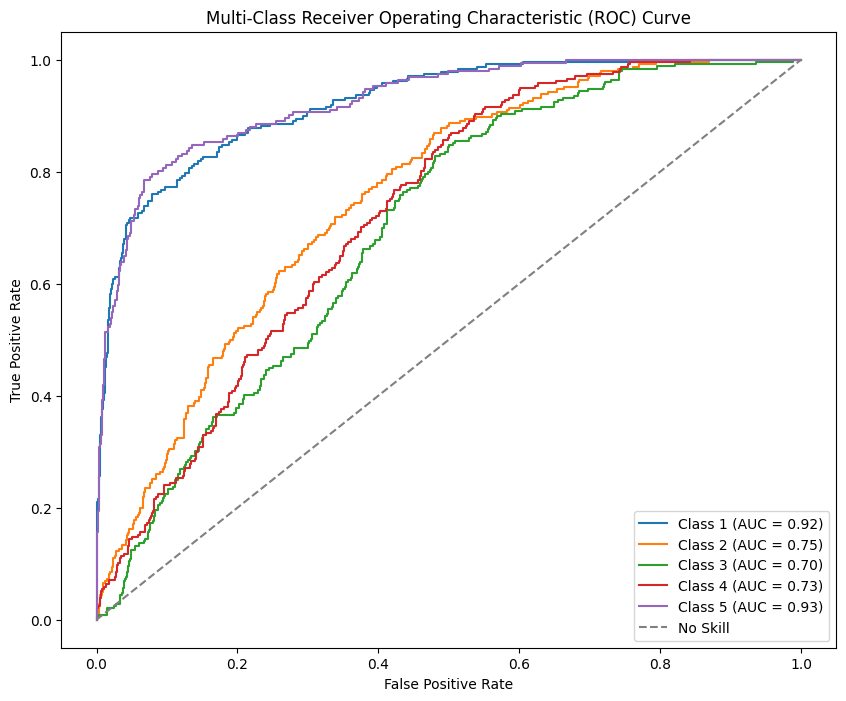

In [74]:
#Plotting the Multi-Class ROC Curve
# Binarize the output labels (One-vs-Rest encoding)
Y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# Define the number of classes
n_classes = lda_pca_pred_probs.shape[1]

# Create a figure for the plot
plt.figure(figsize=(10, 8))

# Loop through each class and plot the ROC curve
for i in range(n_classes):
    # Compute the ROC curve and AUC for each class
    fpr, tpr, thresholds= roc_curve(Y_test_binarized[:, i], lda_pca_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for this class
    plt.plot(fpr, tpr, label=f'Class {np.unique(Y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot the "no skill" line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Skill')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')